In [155]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)
from collections import namedtuple

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import tqdm
import joblib

sys.path.append("../../../python")
from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
from simhelper import helper_plt as hplt
reload(parser)
reload(datatypes)

sys.path.append("..")
import cut_functions
reload(cut_functions)

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

# Plot settings
reload(hplt)
hplt.plt_config() # Default plotting styles
%config InlineBackend.figure_format='retina'
save_fig = hplt.Save_fig(fig_prefix="plots/", exts="pdf,jpg",dpi=200,SAVE=True)

# Load data

In [ ]:
efficiency=0.95
data_dir="/home/tomren/geant_projects/musim_test/"

filenames = {\
    "bkg p": f"{data_dir}/cedar/cosmic/cosmic_p/skim/rrq_bkg_eff{efficiency:.2f}.joblib",\
    "bkg n": f"{data_dir}/cedar/cosmic/cosmic_n/skim/rrq_bkg_eff{efficiency:.2f}.joblib",\
    "bkg mu": f"{data_dir}/cedar/muon/rrq_bkg_eff{efficiency:.2f}.joblib",\
    "bkg v": f"{data_dir}/cedar/neutrino/rrq_bkg_eff{efficiency:.2f}.joblib",\
    "sig 15": f"{data_dir}/llp_hxx_bb/skim/rrq_sig_15_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 25": f"{data_dir}/llp_hxx_bb/skim/rrq_sig_25_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 35": f"{data_dir}/llp_hxx_bb/skim/rrq_sig_35_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 45": f"{data_dir}/llp_hxx_bb/skim/rrq_sig_45_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 55": f"{data_dir}/llp_hxx_bb/skim/rrq_sig_55_cosmic_eff{efficiency:.2f}.joblib",\
}

In [ ]:
## Load raw data
raw = {item: joblib.load(filenames[item]) for item in filenames}

In [118]:
## Convert raw data to an object that manages cuts
data = {item: cut_functions.RQ_dict(raw[item]) for item in filenames}

# Add cuts

In [119]:
def c_fid(res):
    pillar_locations = [[i*10700,j*10700] for i in range(-2,2) for j in range(-2,3)]
    pillar_locations_right = [[i*10700,j*10700] for i in [2] for j in range(-2,3)]
    cut_range = 1000
    cut_range_right = 1200
    mask = np.ones_like(res["vertex_ndigi"], dtype=bool)
    for x,y in pillar_locations:
        mask = mask & ((abs(res["vertex_xyzt"][:,0]-x)>cut_range) | (abs(res["vertex_xyzt"][:,1]-y)>cut_range))

    for x,y in pillar_locations_right:
        mask = mask & ((abs(res["vertex_xyzt"][:,0]-x)>cut_range_right) | (abs(res["vertex_xyzt"][:,1]-y)>cut_range_right))    
    return mask

f_ndown_cut = lambda x: ((x-6)*.8 + 0.5) * (x >=6) + 0.5 * (x<6)
c_ndown = lambda data: (res["event_ndownward_track"][:,0] + res["event_ndownward_track"][:,1])< f_ndown_cut(res["event_ntracks"])

def f_nhits_cut(x):
    x0 = 35
    squeeze = 10
    yscale = 120
    slope = 0.3
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    return y
c_nhits = lambda data: (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"]) < f_nhits_cut(res["vertex_ndigi_active_after_comp"])


def f_nhits_cut2(x):
    x0 = 15
    squeeze = 5
    yscale = 100
    slope = 1
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    # return y * (y>20) + 20 * (y<=20)
    return y
c_nhits2 = lambda data: (res["event_nhits"] - res["vertex_ndigi_active_after_comp"]) < f_nhits_cut2(res["event_track_nhits"])

c_track_before = lambda data: res["vertex_ndigi_before_limited"] <= 0

cut_angel_v1 = 0.3
cut_angel_v2 = 0.6
c_angle_hv = lambda data: (abs(res["vertex_cms_angle_h"]) + abs(res["vertex_cms_angle_v"]) < cut_angel_v1) | \
        (((-res["vertex_cms_angle_h"] - res["vertex_cms_angle_v"]) < cut_angel_v2) & (res["vertex_cms_angle_h"]<0.02) & (res["vertex_cms_angle_v"]<0.02))

for i, res in data.items():
    # More than 2 tracks:
    ## A cut called "More than 2 tracks" is automatically added already.
    
    # More than 3 tracks
    res.add_cut(lambda res: res["vertex_ntracks"]>3, "More than 3 tracks")   

    # Fiducial volume
    res.add_cut(c_fid, "Fiducial volume")

    # Number of veto hits versus consistent hits
    res.add_cut(c_nhits, "N_hits vs N_veto")

    # Number of veto hits versus consistent hits version 2
    res.add_cut(c_nhits2, "N_hits vs N_veto 2")
    
    # Numeber of downward track
    res.add_cut(c_ndown, "N track downward")

    # Speed of slowest track
    res.add_cut(lambda res: (res["vertex_slowest_track"]> 220) & (res["vertex_slowest_track"]<320), "Track velocity")
    
    # Number of hits before the vertex
    res.add_cut(c_track_before, "N digi before")

    # Align with CMS
    res.add_cut(c_angle_hv, "Angle to CMS")


In [120]:
def append_info_dict(dict_a, dict_b):
    if len(dict_a.keys()) == 0:
        for key,value in dict_b.items():
            dict_a[key] = [value[0]]
    else:
        for key,value in dict_b.items():
            dict_a[key].append(value[0])

def print_info_dict(info, col_names):
    str_print = []
    str_save = []

    # Prepare header line
    str_save.append(f" ")
    str_print.append(" "*20)
    [str_save.append(f",{v}") for v in col_names]
    [str_print.append(f"{v:>8}") for v in col_names]
    str_save.append("\n")
    str_print.append("\n")
    
    for key,value in info.items():
        str_save.append(f"{key}")
        str_print.append(f"{key:<20}")
        [str_save.append(f",{v}") for v in value]
        [str_print.append(f"{v:>8}") for v in value]
        str_save.append("\n")
        str_print.append("\n")
    str_print = "".join(str_print)
    print(str_print)
    return "".join(str_save)

In [208]:
## Show all cuts added
## You don't need to use all of them
data["bkg n"].list_cut()

Cut 0 : More than 2 tracks  , npassed   3423, passage fraction 0.0156367
Cut 1 : True                , npassed 218908, passage fraction 1.0000000
Cut 2 : More than 3 tracks  , npassed    216, passage fraction 0.0009867
Cut 3 : Fiducial volume     , npassed 200440, passage fraction 0.9156358
Cut 4 : N_hits vs N_veto    , npassed     19, passage fraction 0.0000868
Cut 5 : N_hits vs N_veto 2  , npassed  10357, passage fraction 0.0473121
Cut 6 : N track downward    , npassed 154691, passage fraction 0.7066485
Cut 7 : Track velocity      , npassed 171860, passage fraction 0.7850787
Cut 8 : N digi before       , npassed  69847, passage fraction 0.3190701
Cut 9 : Angle to CMS        , npassed  23979, passage fraction 0.1095392


# Show cutflow with "more than 2 tracks" cut

In [295]:
cut_info_a = {}
cut_info_b = {}

cols = []
for name, res in data.items():
    cut_fiducial = []
    cuts_indirect = [3,8,7,9]
    cuts_direct = [0,6,4,5]
    
    res.cuts_active = cut_fiducial + cuts_indirect + cuts_direct
    info_a = res.print_active(show=False)

    res.cuts_active = cut_fiducial + cuts_direct + cuts_indirect
    info_b = res.print_active(show=False)

    append_info_dict(cut_info_a, info_a)
    append_info_dict(cut_info_b, info_b)
    cols.append(name)

In [296]:
info_a = print_info_dict(cut_info_a, cols)
info_b = print_info_dict(cut_info_b, cols)
with open("info_a_2track.csv", "w+") as f:
    f.write(info_a)
with open("info_b_2track.csv", "w+") as f:
    f.write(info_b)    

abcd_p = cut_info_a["Angle to CMS"][0]*cut_info_b["N_hits vs N_veto 2"][0]/cut_info_a["Total"][0] * 32
abcd_n = cut_info_a["Angle to CMS"][1]*cut_info_b["N_hits vs N_veto 2"][1]/cut_info_a["Total"][1] * 27
print("Extrapolated 5-year background for proton:", abcd_p)
print("Extrapolated 5-year background for neutron:", abcd_n)

                       bkg p   bkg n  bkg mu   bkg v  sig 15  sig 25  sig 35  sig 45  sig 55
Total                 638739  218908   23689      24    8601    9057    9055    8964    8846
Fiducial volume       566577  200440   23056      22    8356    8806    8802    8708    8598
N digi before          55494   57386      17       0    7938    8318    8254    8121    7950
Track velocity         42910   44924      17       0    7707    8119    8090    7945    7748
Angle to CMS            4013    4630      15       0    7167    7104    6622    5897    4785
More than 2 tracks       186     101       0       0    6442    6595    6269    5606    4542
N track downward          63      50       0       0    6207    6369    6038    5387    4338
N_hits vs N_veto           0       0       0       0    5871    6064    5808    5129    4098
N_hits vs N_veto 2         0       0       0       0    5837    6037    5783    5095    4056

                       bkg p   bkg n  bkg mu   bkg v  sig 15  sig 25 

# With >3 tracks cut

In [286]:
cut_info_a = {}
cut_info_b = {}

cols = []
for name, res in data.items():
    cut_fiducial = []
    cuts_indirect = [3,8,7,9]
    cuts_direct = [2,6,4,5]
    
    res.cuts_active = cut_fiducial + cuts_indirect + cuts_direct
    info_a = res.print_active(show=False)

    res.cuts_active = cut_fiducial + cuts_direct + cuts_indirect
    info_b = res.print_active(show=False)

    append_info_dict(cut_info_a, info_a)
    append_info_dict(cut_info_b, info_b)
    cols.append(name)

In [287]:
info_a = print_info_dict(cut_info_a, cols)
info_b = print_info_dict(cut_info_b, cols)
with open("info_a_3track.csv", "w+") as f:
    f.write(info_a)
with open("info_b_3track.csv", "w+") as f:
    f.write(info_b)    

abcd_p = cut_info_a["Angle to CMS"][0]*cut_info_b["N_hits vs N_veto 2"][0]/cut_info_a["Total"][0] * 32
abcd_n = cut_info_a["Angle to CMS"][1]*cut_info_b["N_hits vs N_veto 2"][1]/cut_info_a["Total"][1] * 27
print("Extrapolated 5-year background for proton:", abcd_p)
print("Extrapolated 5-year background for neutron:", abcd_n)

                       bkg p   bkg n  bkg mu   bkg v  sig 15  sig 25  sig 35  sig 45  sig 55
Total                 638739  218908   23689      24    8601    9057    9055    8964    8846
Fiducial volume       566577  200440   23056      22    8356    8806    8802    8708    8598
N digi before          55494   57386      17       0    7938    8318    8254    8121    7950
Track velocity         42910   44924      17       0    7707    8119    8090    7945    7748
Angle to CMS            4013    4630      15       0    7167    7104    6622    5897    4785
More than 3 tracks        10       4       0       0    5155    5645    5509    4950    4001
N track downward           2       1       0       0    5033    5522    5357    4811    3876
N_hits vs N_veto           0       0       0       0    4859    5350    5229    4663    3726
N_hits vs N_veto 2         0       0       0       0    4859    5348    5223    4656    3707

                       bkg p   bkg n  bkg mu   bkg v  sig 15  sig 25 

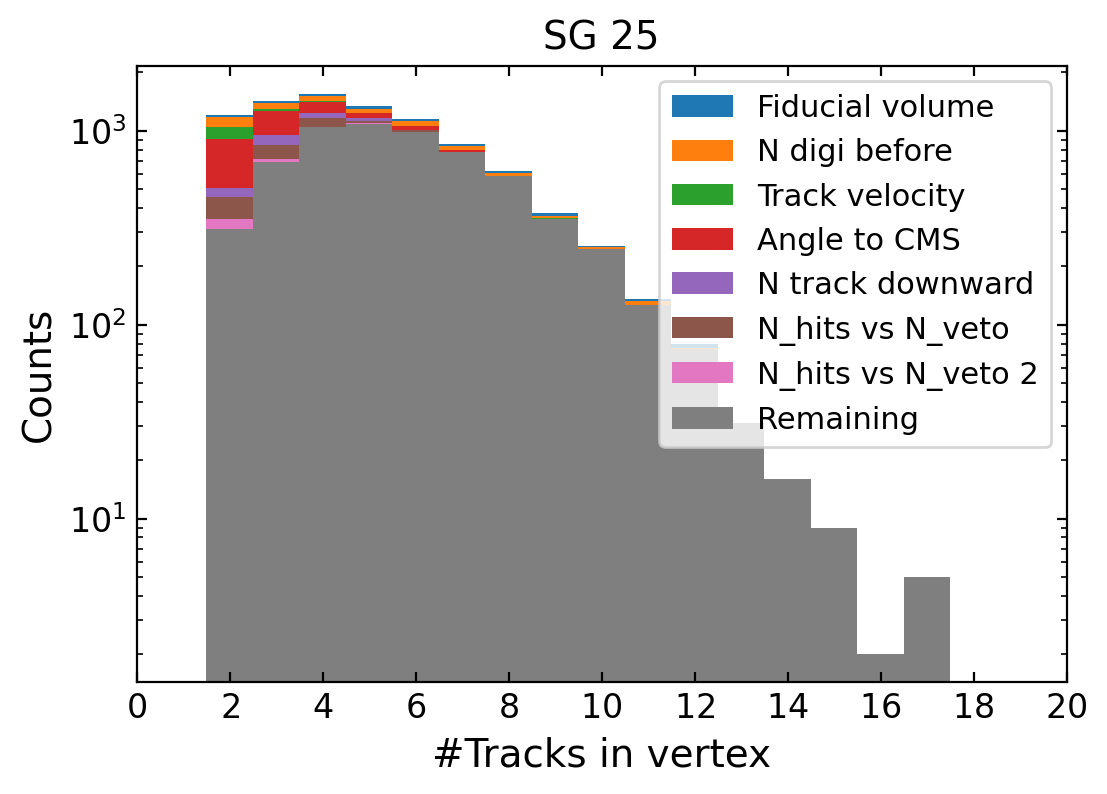

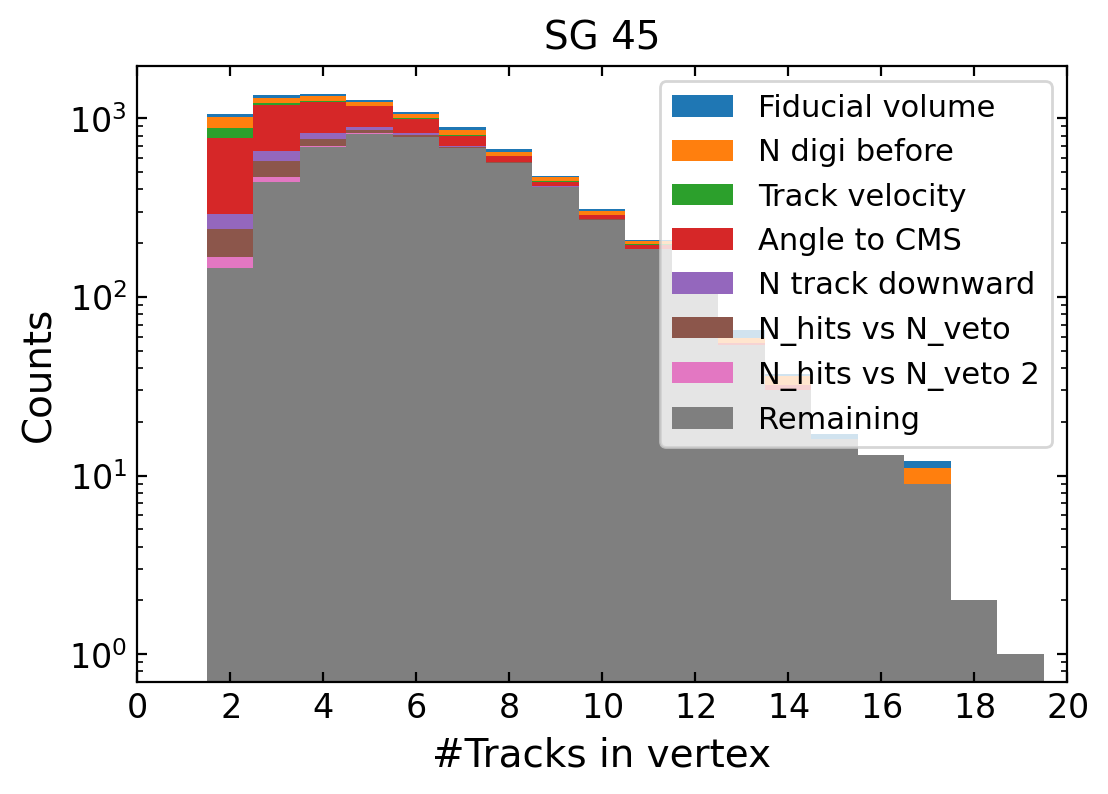

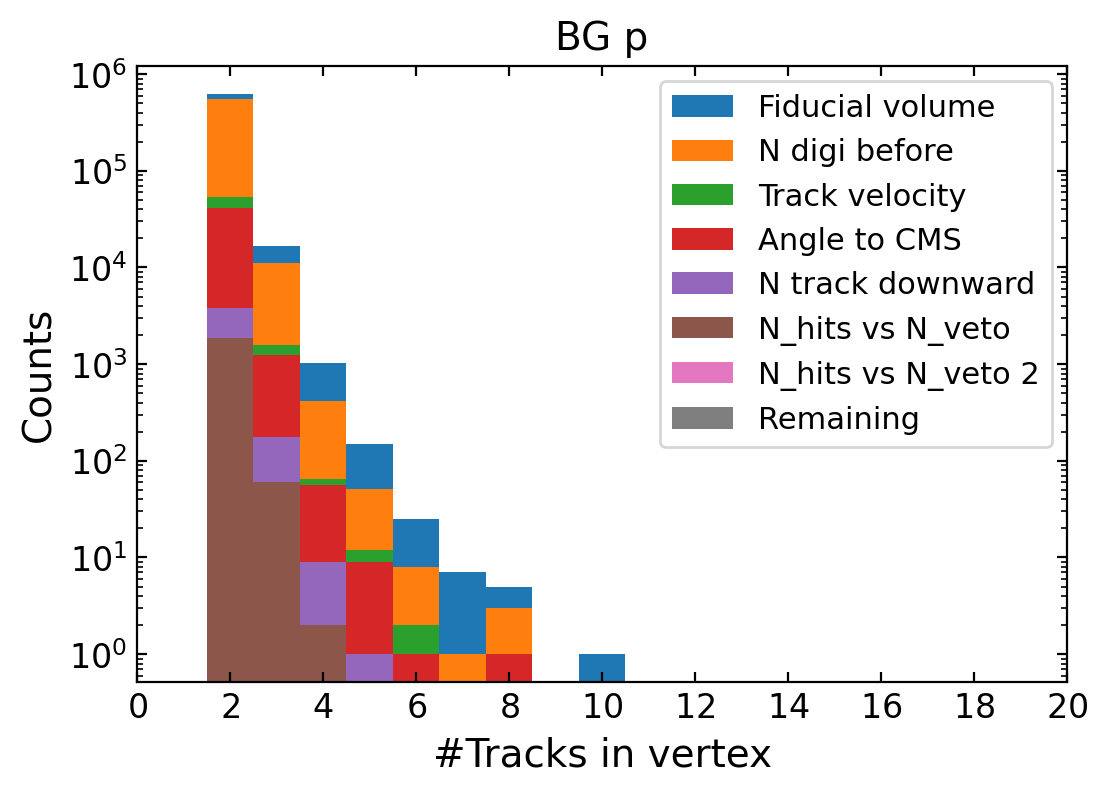

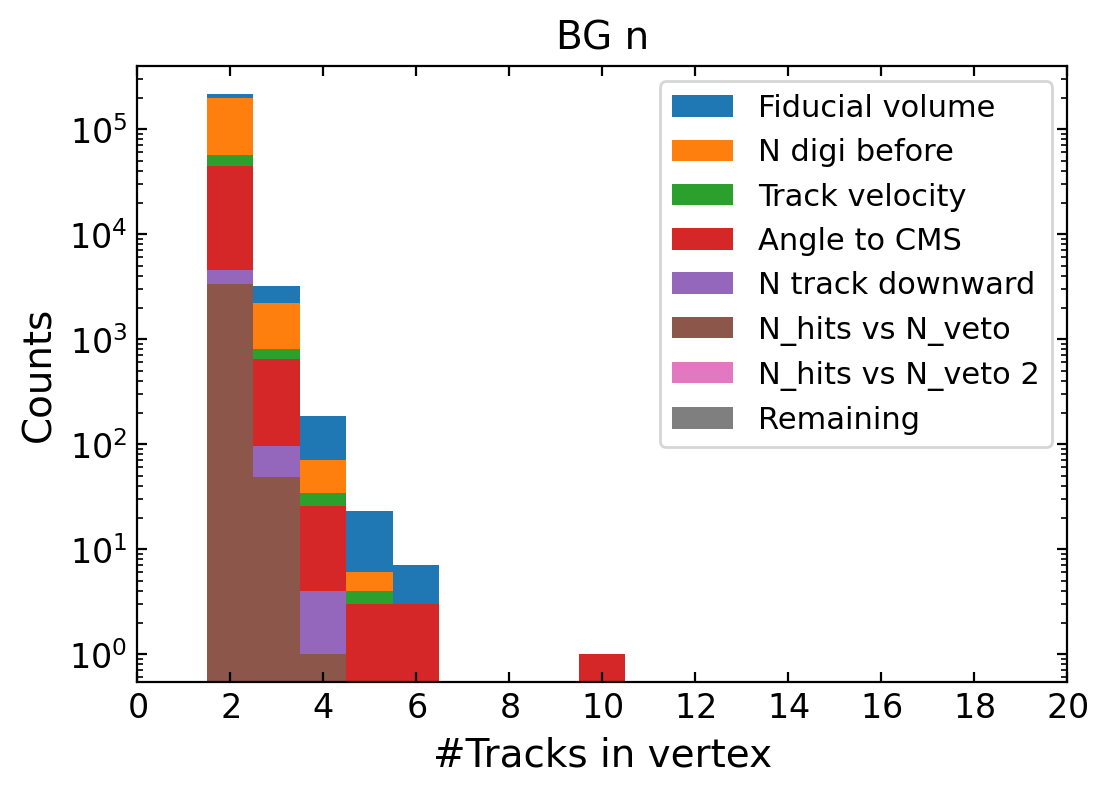

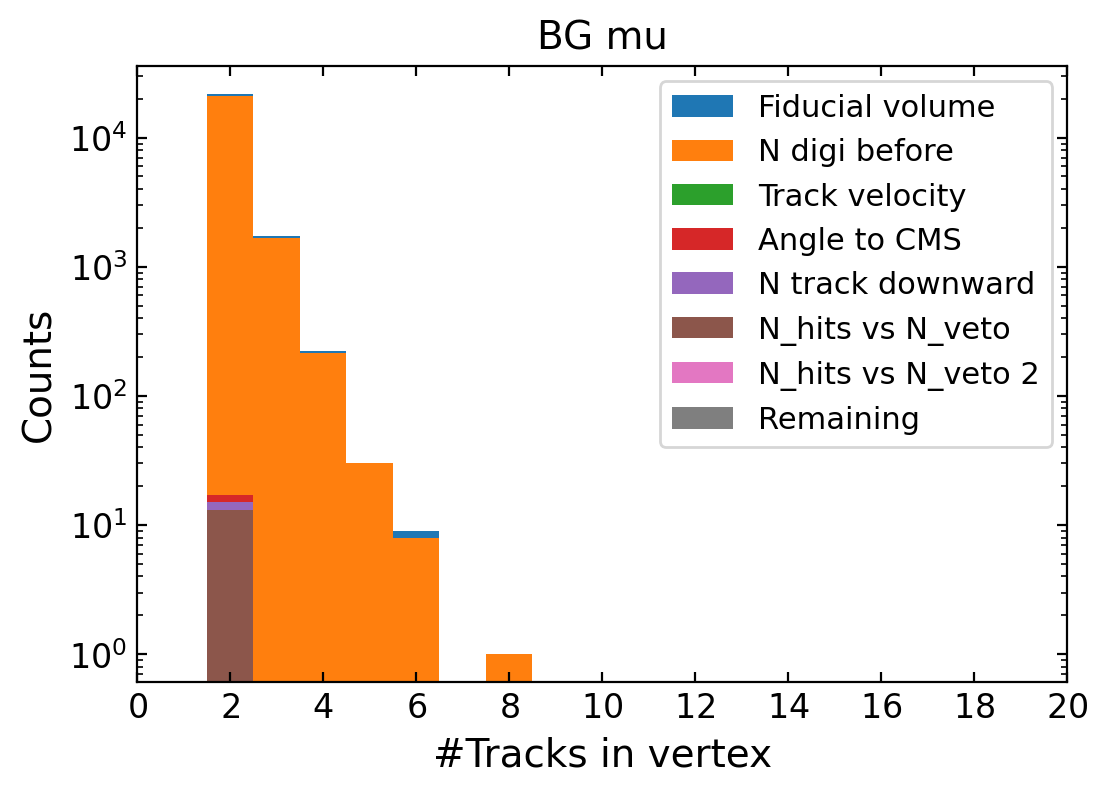

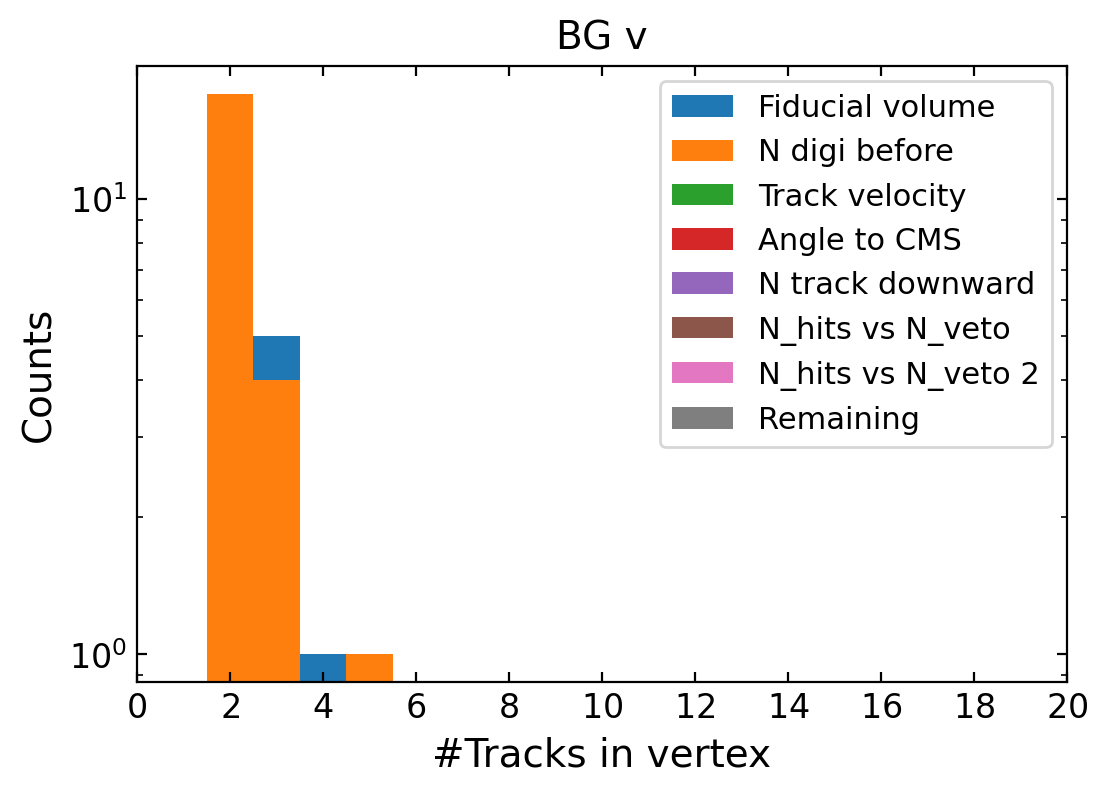

In [285]:
cut_fiducial = [3]
cuts_indirect = [8,7,9]
cuts_direct = [6,4,5]

cuts_active = cut_fiducial + cuts_indirect + cuts_direct
# cuts_active = cut_fiducial + cuts_direct + cuts_indirect    

for name, cfg in plot_settings.items():
    res = data[name]
    
    mask = res.get_cut("True")
    bins = np.linspace(0.1, 2e2,100)
    plt.hist(res["vertex_ntracks"][mask], bins=21,range=(-0.5,20.5), label=res.cuts_name[cuts_active[0]]);
    
    n_plotted = 0
    for i in cuts_active:
        name = res.cuts_name[i]
        mask = mask & res.cuts_dict[name].get_mask()    
        label = res.cuts_name[cuts_active[n_plotted+1]] if n_plotted+1<len(cuts_active) else "Remaining"
        plt.hist(res["vertex_ntracks"][mask], bins=21,range=(-0.5,20.5), alpha=1, label=label);
        n_plotted+=1
        
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
    plt.yscale("log")
    plt.xlabel("#Tracks in vertex")
    plt.ylabel("Counts")
    plt.legend()
    plt.xlim(0,20)
    plt.title(cfg.label)
    plt.show()

# All plots

In [233]:
NTRACK=3

In [179]:
pltconfig = namedtuple("pltconfig", ["color","label","marker","markersize", "histtype", "alpha_marker"])

plot_settings = {\
    "sig 25": pltconfig("C0", "SG 25","s", 6, "step", 0.5),\
    "sig 45": pltconfig("C2", "SG 45","s", 6, "step", 0.5),\
    "bkg p":  pltconfig("C1", "BG p", "p", 4, "bar", 0.2),\
    "bkg n":  pltconfig("C3", "BG n", "p", 4, "bar", 0.2),\
    "bkg mu": pltconfig("C4", "BG mu","^", 4, "bar", 0.2),\
    "bkg v":  pltconfig("C5", "BG v", "v", 4, "bar", 0.2),\
}

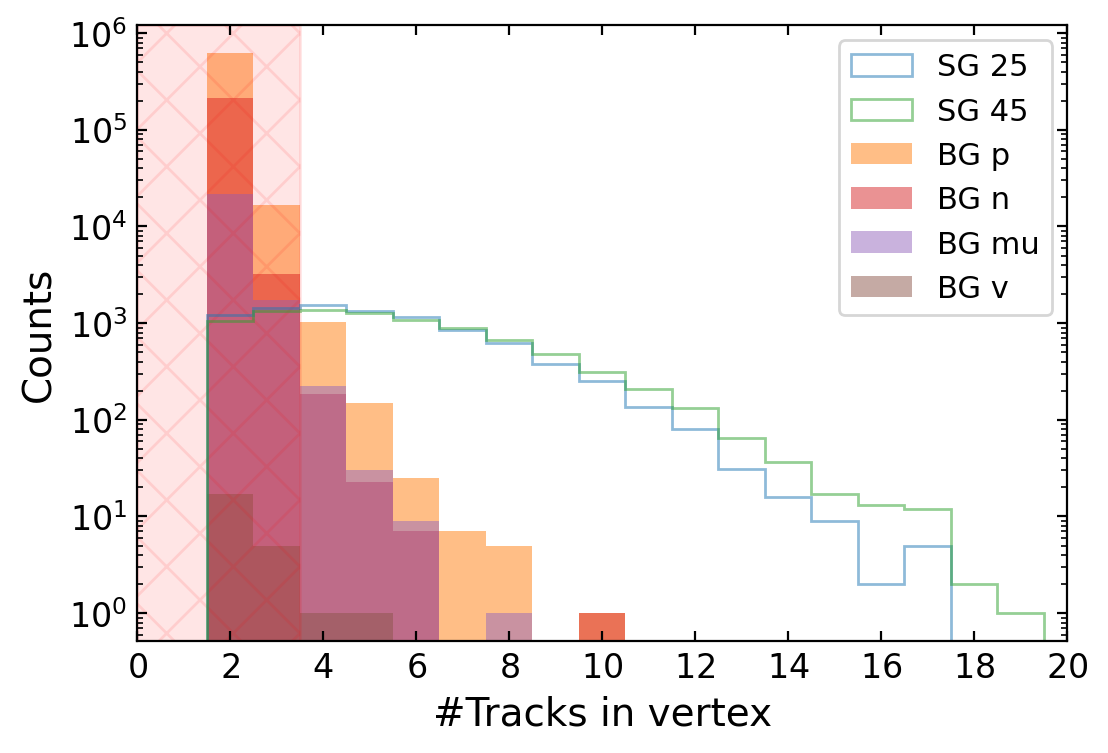

In [232]:
for name, cfg in plot_settings.items():
    res = data[name]
    plt.hist(res["vertex_ntracks"], bins=21,range=(-0.5,20.5), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)


plt.axvspan(0,NTRACK+0.5,color="r", alpha=0.1, hatch="X")


plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("#Tracks in vertex")
plt.ylabel("Counts")
plt.legend()
plt.xlim(0,20)
save_fig("comb_ntrack_hits")
plt.show()

8806
0.0 8.0


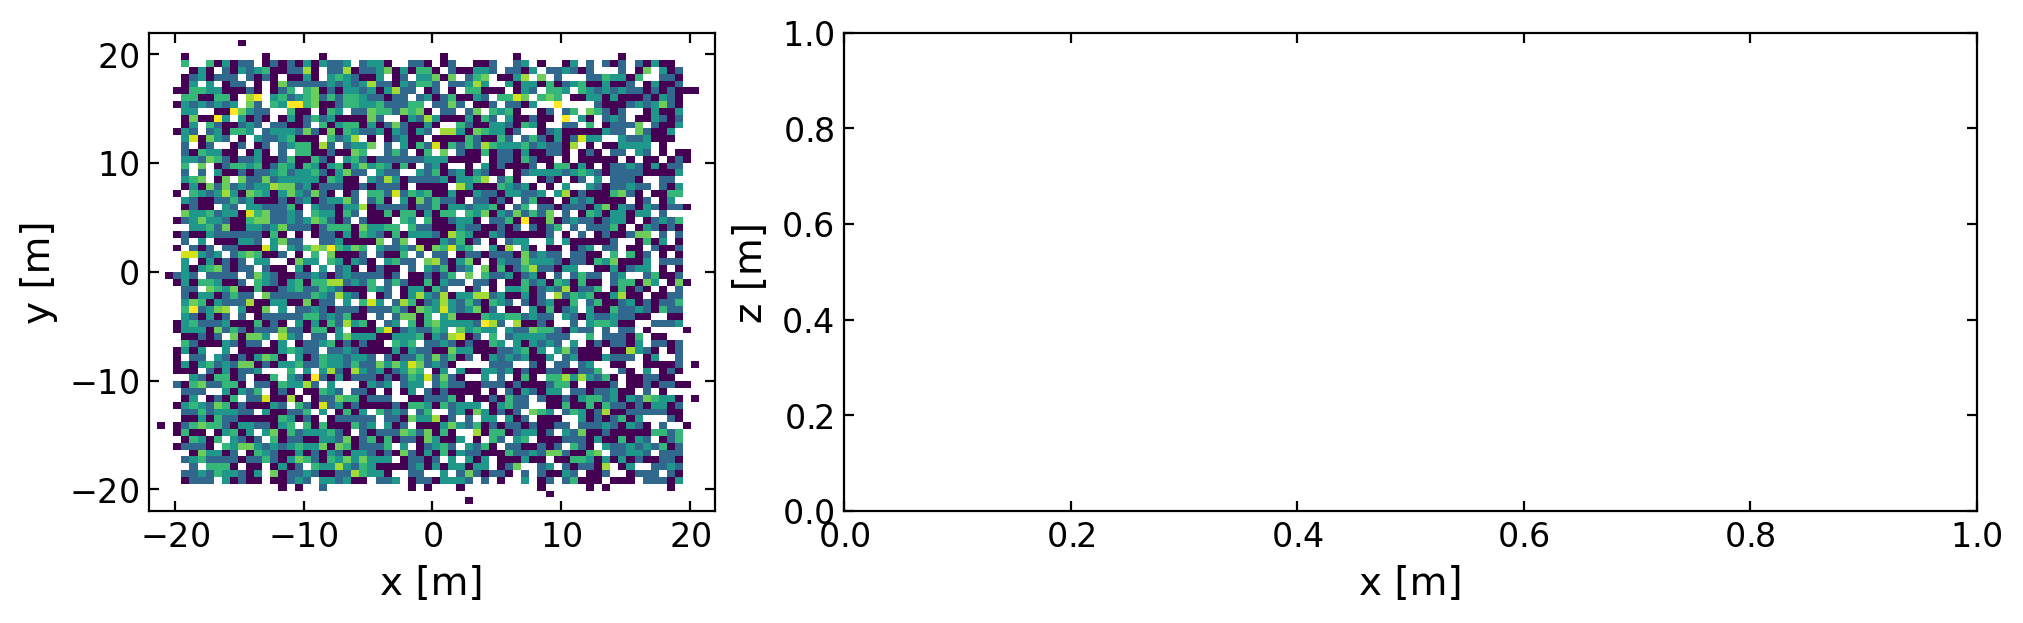

8708
0.0 10.0


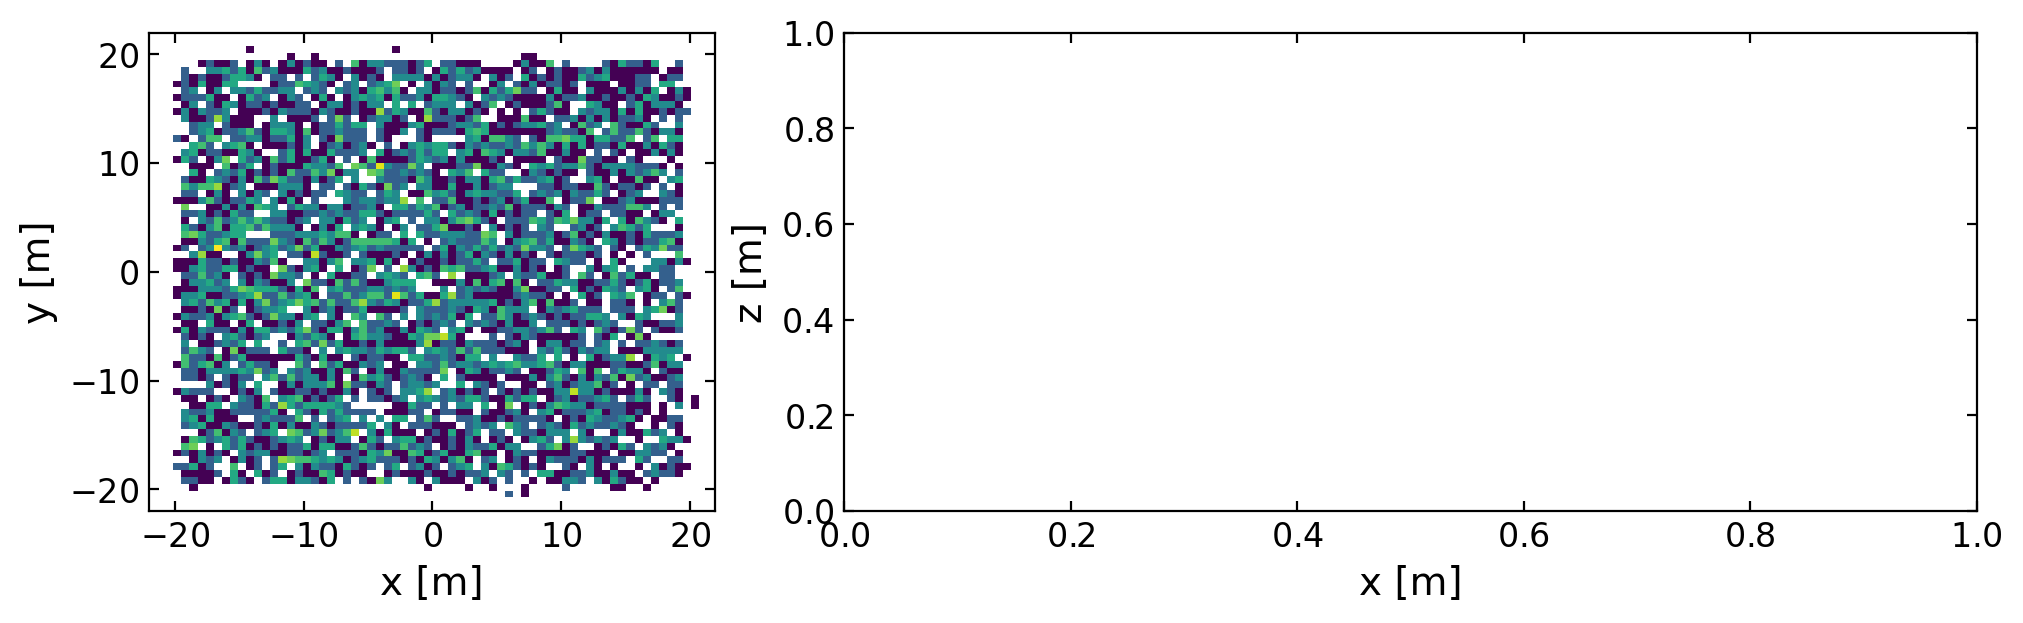

566577
0.0 170.0


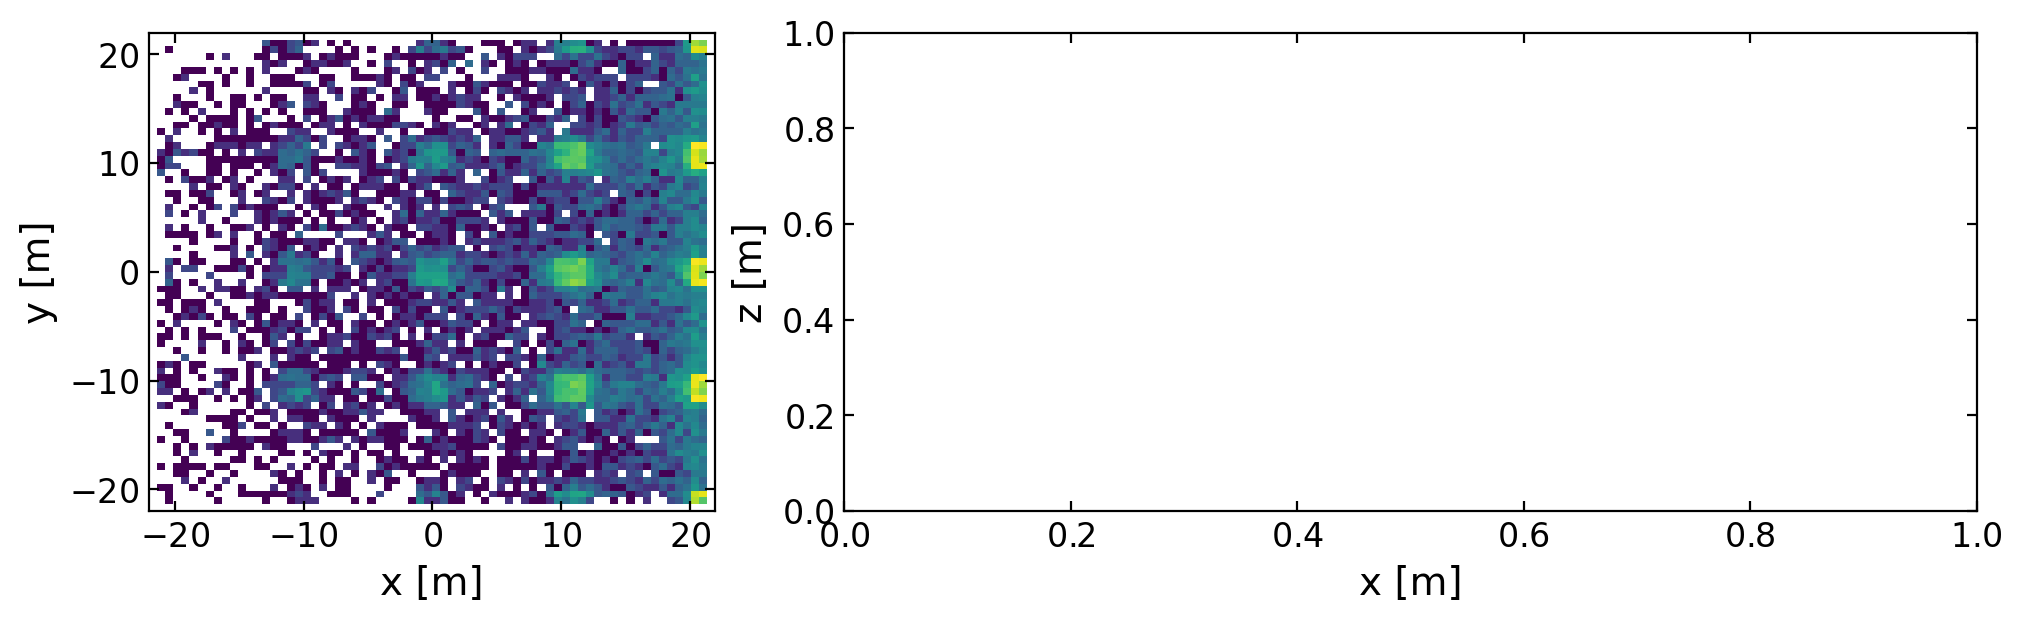

200440
0.0 37.0


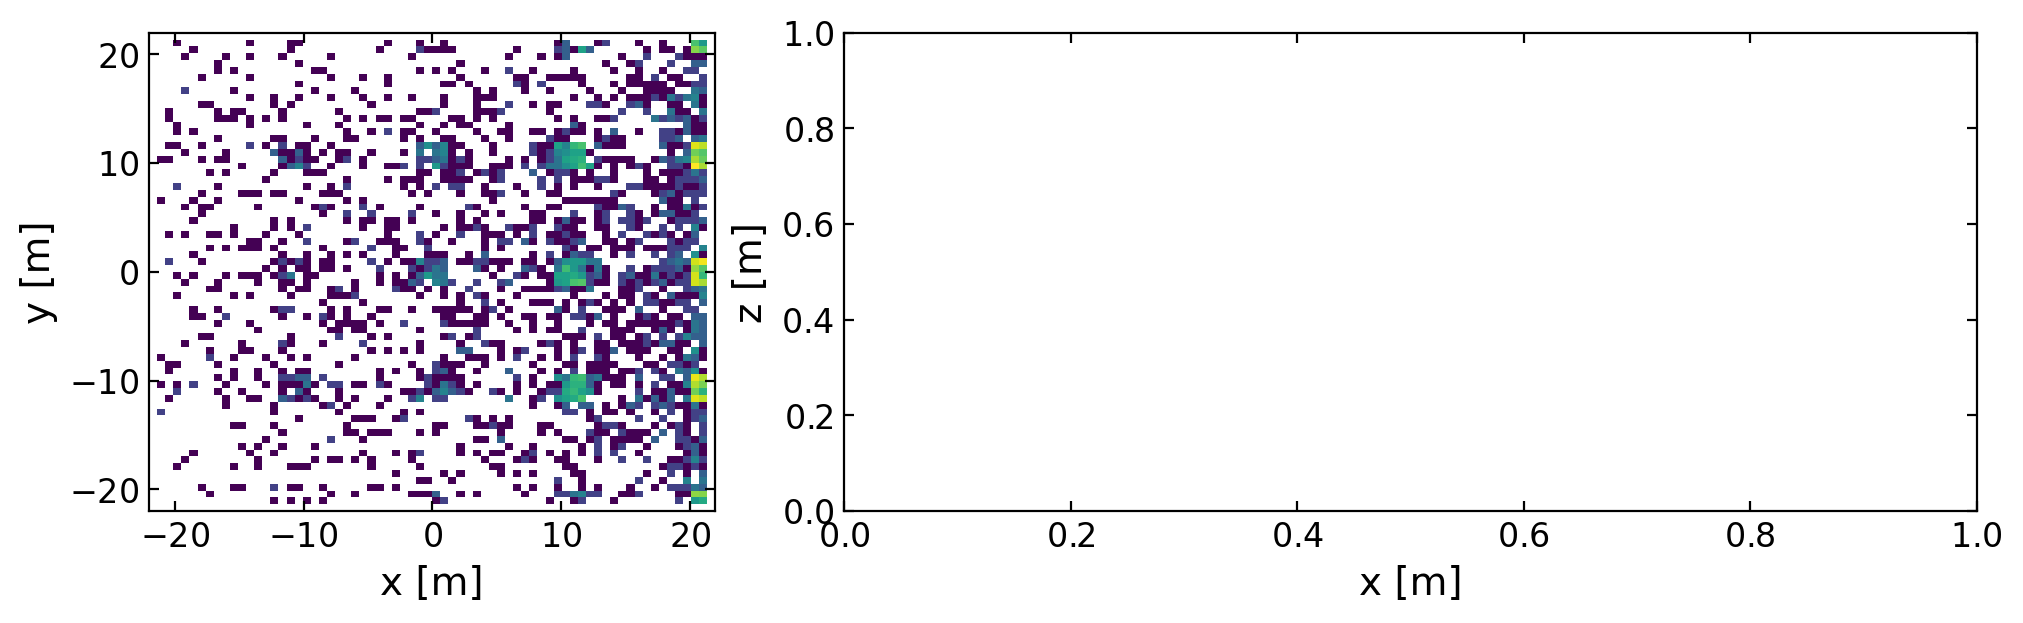

23056
0.0 5.0


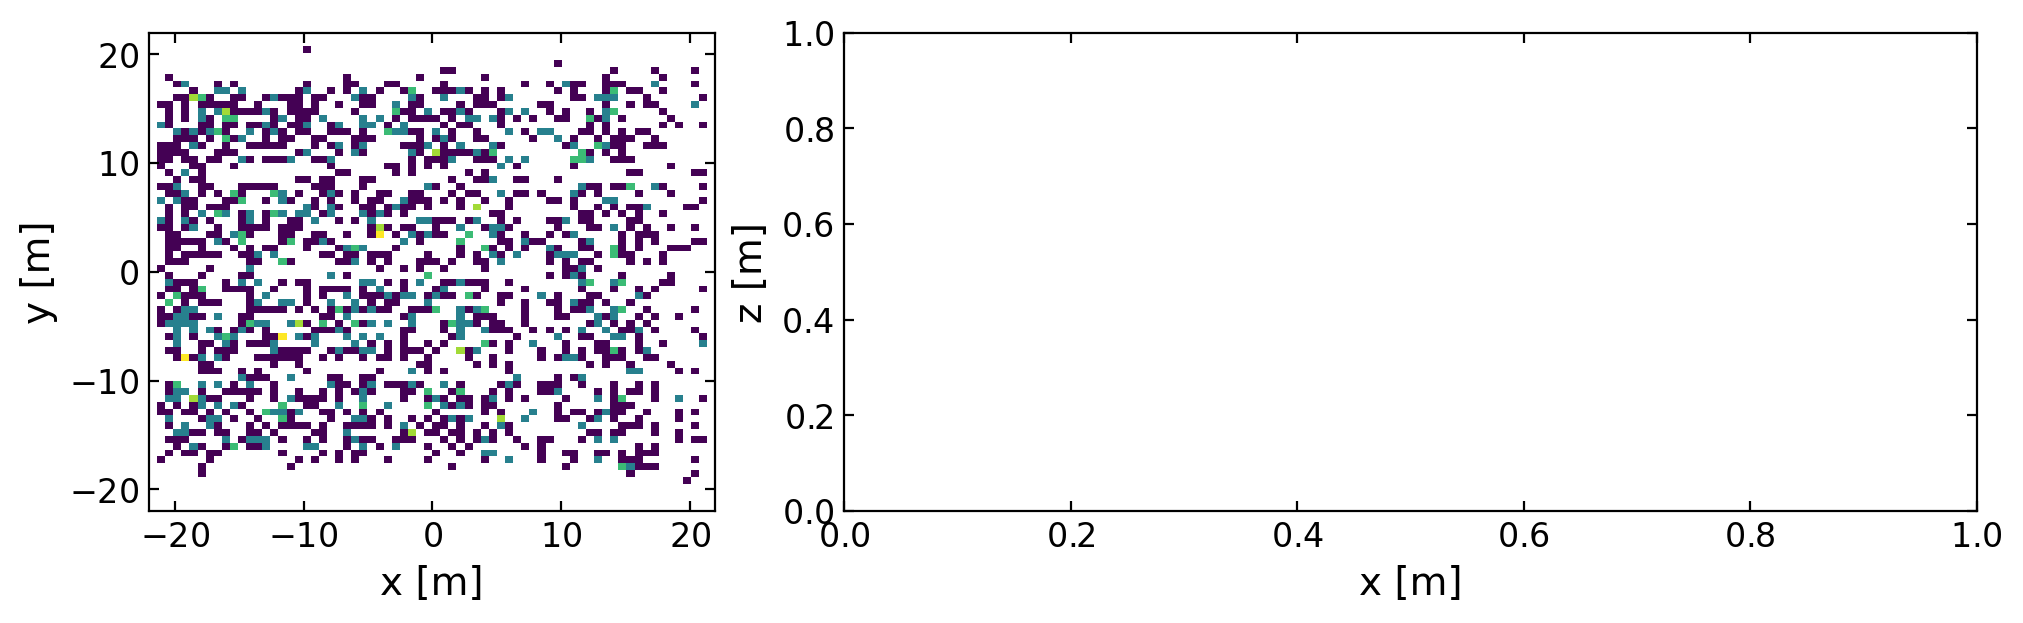

22
0.0 1.0


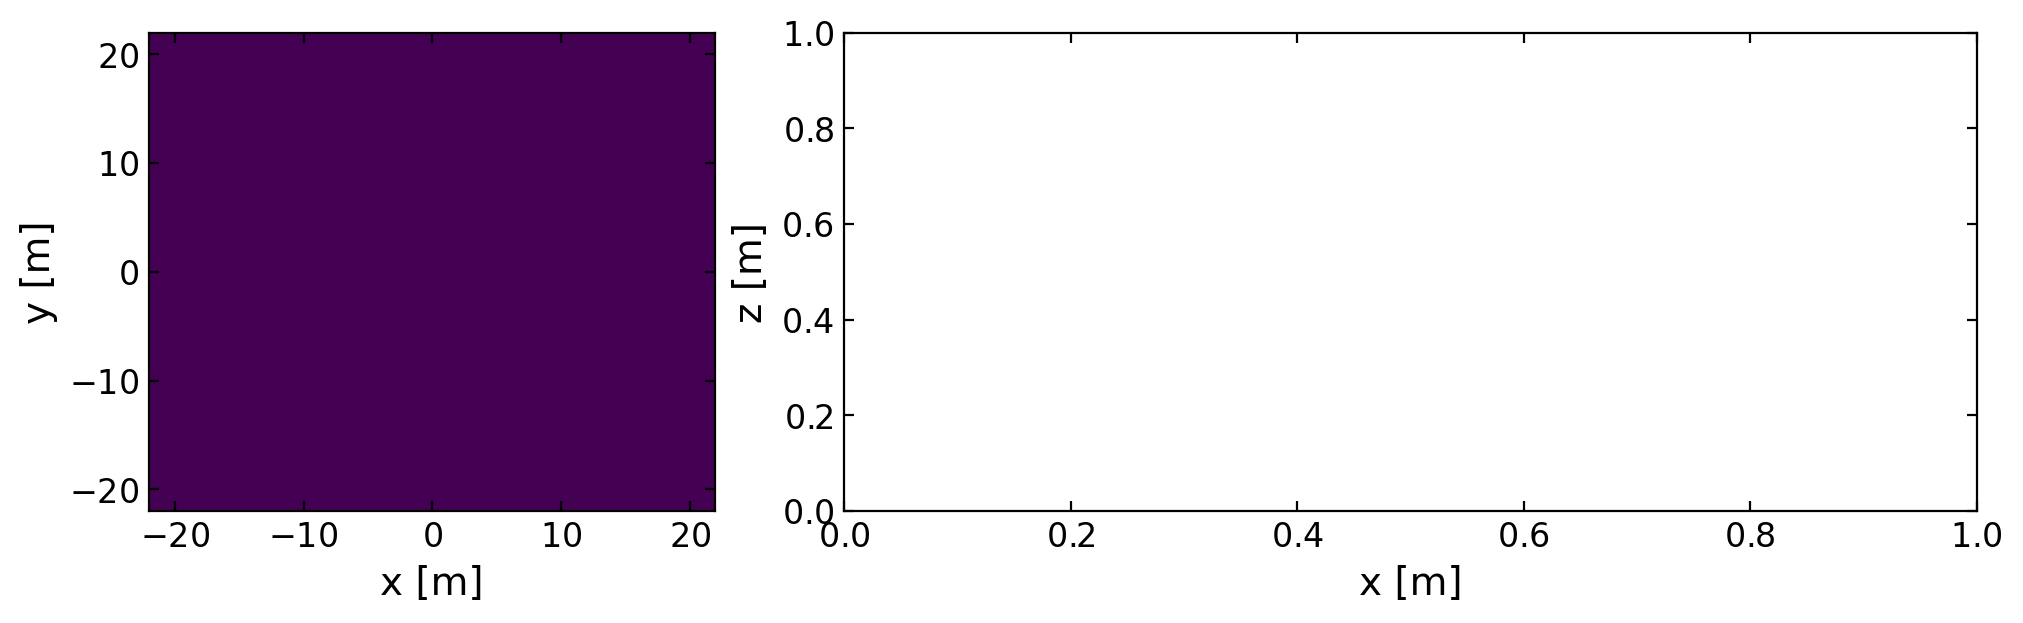

In [329]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    # mask = res.get_cut(f"More than {NTRACK} tracks") & res.get_cut("Fiducial volume") # & res.get_cut("N track downward")#| res.get_cut("True")
    mask = res.get_cut(f"More than 2 tracks") #& res.get_cut("Fiducial volume") # & res.get_cut("N track downward")#| res.get_cut("True")
    mask_fid = res.get_cut("Fiducial volume")#| res.get_cut("True")
    print(sum(mask_fid))
    
    fig = plt.figure(figsize=(10,3), layout="constrained")
    spec = fig.add_gridspec(1,3)
    
    ax1 = fig.add_subplot(spec[:, :1])
    ax2 = fig.add_subplot(spec[:, 1:])


    x = (res["vertex_xyzt"][:,0])[mask]/1000
    y = (res["vertex_xyzt"][:,1])[mask]/1000
    x_reject = (res["vertex_xyzt"][:,0])[mask&mask_fid]/1000
    y_reject = (res["vertex_xyzt"][:,1])[mask&mask_fid] /1000   
    h,xe,ye = hp.histogram2d(x, y, bins=(70,70), range=((-22,22),(-22,22)))
    print(np.min(h), np.max(h))
    ax1.hist2d(x, y, bins=(70,70), range=((-22,22),(-22,22)), norm=mpl.colors.LogNorm(vmin = 1, vmax = np.max(h)))
    # ax1.hist2d(x_reject, y_reject, bins=(70,70), range=((-22,22),(-22,22)), norm=mpl.colors.LogNorm(vmin = 1, vmax = np.max(h)))
    # ax1.scatter(x_reject, y_reject, alpha=0.83, s=1, color="r")
    # plt.colorbar()
    ax1.set_xlabel("x [m]")
    ax1.set_ylabel("y [m]")

    x = (res["vertex_xyzt"][:,0])[mask]/1000
    y = (res["vertex_xyzt"][:,2])[mask]/1000
    # ax2.hist2d(x, y, bins=(80,40), norm=mpl.colors.LogNorm())
    ax2.set_xlabel("x [m]")
    ax2.set_ylabel("z [m]")
    
    plt.show()

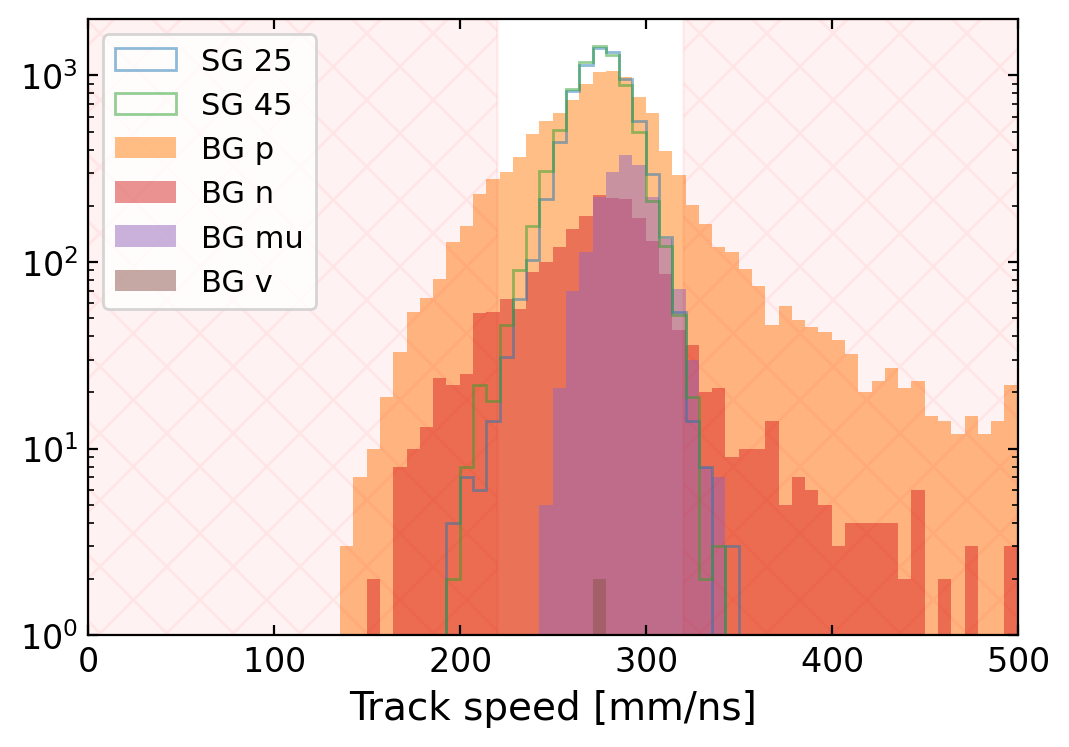

In [237]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask = res.get_cut("More than 2 tracks") & res.get_cut("Fiducial volume")#& res.get_cut("N track downward")
    # mask = res.get_cut(f"More than {NTRACK} tracks") & res.get_cut("Fiducial volume")
    
    plt.hist(res["vertex_slowest_track"][mask], bins=70,range=(0,500),alpha=0.5, color=cfg.color, label=cfg.label, histtype=cfg.histtype)

    
plt.xlabel("Track speed [mm/ns]")
plt.ylim(1,2e3)
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 0, 220, color="r", alpha=0.05, hatch="X")
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 320, 500, color="r", alpha=0.05, hatch="X")

plt.xlim(0,500)
plt.yscale("log")
plt.legend()
save_fig("comb_track_speed")
plt.show()

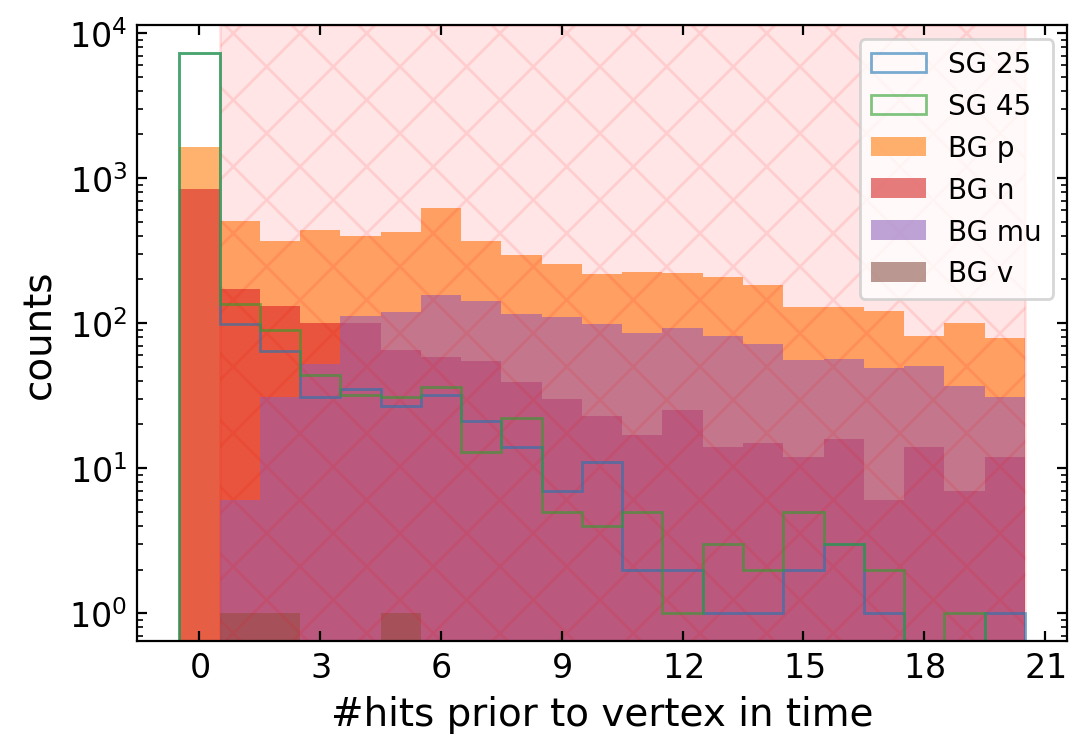

In [291]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask =   res.get_cut("More than 2 tracks") & res.get_cut("Fiducial volume") # res.get_cut("N_hits vs N_veto") &res.get_cut("N_hits vs N_veto 2") #| res.get_cut("True") res.get_cut("N track downward") & res.get_cut("Track velocity") &
    plt.hist(res["vertex_ndigi_before_limited"][mask], range=(-0.5,20.5), bins=21, alpha=0.6,\
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)

plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))

plt.xlabel("#hits prior to vertex in time")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()
plt.axvspan(0.5,20.5,color="r", alpha=0.1, hatch="X")

lh = plt.legend(fontsize=10)
save_fig("comb_nhits_prior")


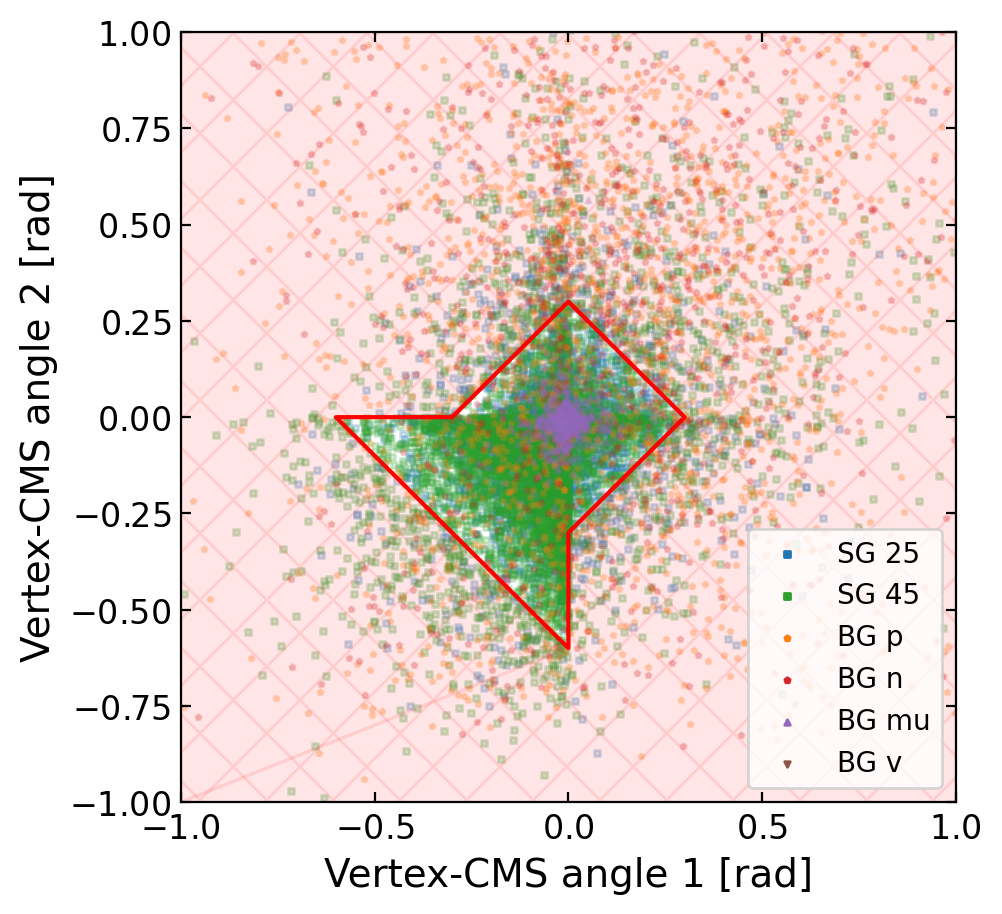

In [331]:

cut_angel_v1 = 0.3
cut_angel_v2 = 0.6
c_angle_hv = lambda data: (abs(res["vertex_cms_angle_h"]) + abs(res["vertex_cms_angle_v"]) < cut_angel_v1) | \
        (((-res["vertex_cms_angle_h"] - res["vertex_cms_angle_v"]) < cut_angel_v2) & (res["vertex_cms_angle_h"]<0.02) & (res["vertex_cms_angle_v"]<0.02))


plt.figure(figsize=(5,5))
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask = res.get_cut("More than 2 tracks") & res.get_cut("N track downward") & res.get_cut("Fiducial volume") # & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("N_hits vs N_veto") & res.get_cut("N_hits vs N_veto 2") # &res.get_cut("N_tracks")  | res.get_cut("True")
    
    x = (res["vertex_cms_angle_h"])[mask]
    y = res["vertex_cms_angle_v"][mask]
    alpha = cfg.alpha_marker*0.4 if "sig" in name else cfg.alpha_marker
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=alpha, s=cfg.markersize)


# Plot the cut region
poly = [[-cut_angel_v1,0], [0, cut_angel_v1], [cut_angel_v1,0], [0, -cut_angel_v1], [0,-cut_angel_v2], [-cut_angel_v2,0]]
polt_out = np.transpose(hplt.fill_outside(np.transpose(poly)[0],np.transpose(poly)[1], [-1,-1],[1,1]))

col1 = mpl.collections.PolyCollection([poly], edgecolors="r")
col1.set_linewidth(1.5)
col1.set_facecolor("none")  # Transparent face
col = mpl.collections.PolyCollection([polt_out], edgecolors="r", alpha=0.1, hatch="X")
col.set_facecolor('r')  # Transparent face
plt.gca().add_collection(col1)
plt.gca().add_collection(col)




plt.xlabel("Vertex-CMS angle 1 [rad]")
plt.ylabel("Vertex-CMS angle 2 [rad]")
# plt.yscale("log")
plt.xlim(-1,1)
plt.ylim(-1,1)

lh = plt.legend(fontsize=10)
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque

save_fig("comb_cms_angle")

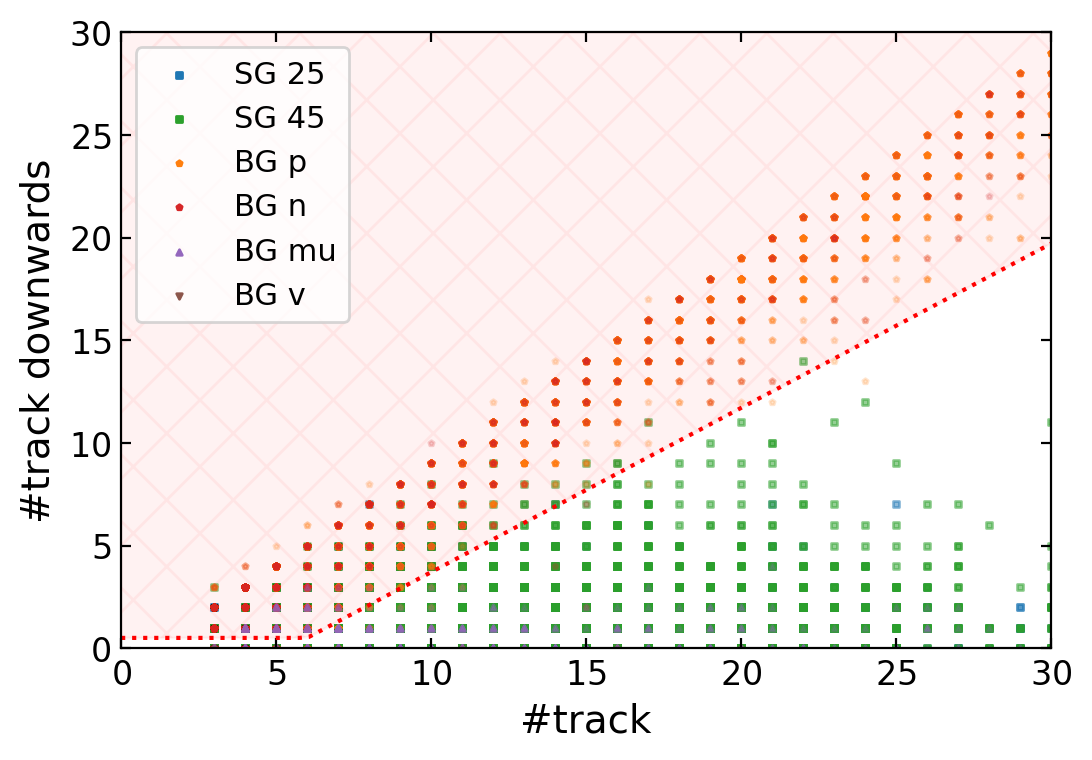

In [241]:
f_ndown_cut = lambda x: ((x-6)*.8 + 0.5) * (x >=6) + 0.5 * (x<6)

for name, cfg in plot_settings.items():
    res = data[name]
    mask = res.get_cut(f"More than 2 tracks") & res.get_cut("Fiducial volume")
    
    x = (res["event_ntracks"])[mask]
    y = (res["event_ndownward_track"][:,0] + res["event_ndownward_track"][:,1])[mask]
    # y = (res["event_ndownward_track"])[mask]
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize)


xlim=30
ylim=30
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_ndown_cut(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_ndown_cut(x_plot), ylim, color="r", alpha=0.05, hatch="X")
plt.xlabel("#track")
plt.ylabel("#track downwards")
plt.xlim(0,xlim)
plt.ylim(0,ylim)
lh = plt.legend(fontsize=11)

# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque

# Save figure
save_fig("comb_n_downward_track")


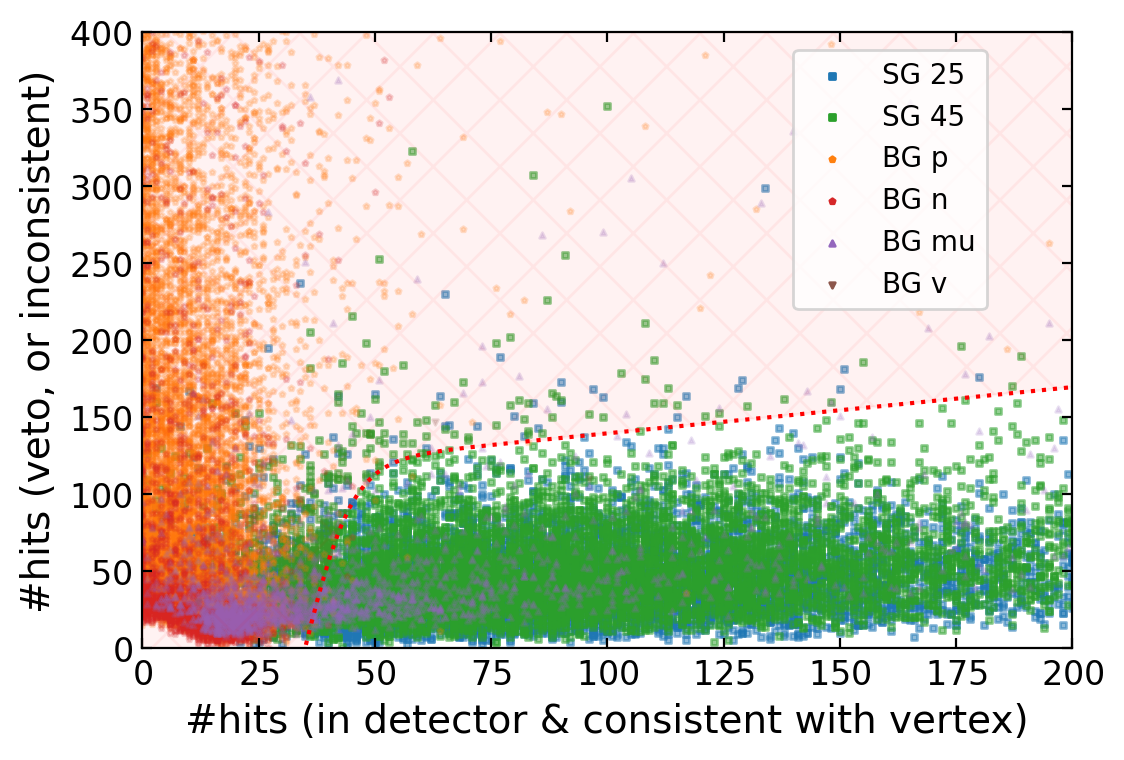

In [294]:
def f_nhits_cut(x):
    x0 = 35
    squeeze = 10
    yscale = 120
    slope = 0.3
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    return y

for name, cfg in plot_settings.items():
    res = data[name]

    mask = res.get_cut("More than 2 tracks") & res.get_cut("Fiducial volume")
    x = (res["vertex_ndigi_active_after_comp"])[mask]
    y = (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"])[mask]
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize)


xlim = 200
ylim = 400
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut(x_plot), ylim, color="r", alpha=0.05, hatch="X")
plt.xlabel("#hits (in detector & consistent with vertex)")
plt.ylabel("#hits (veto, or inconsistent)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

lh = plt.legend(fontsize=10, loc=(0.7,0.55))
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque


save_fig("comb_n_veto_cut_1")

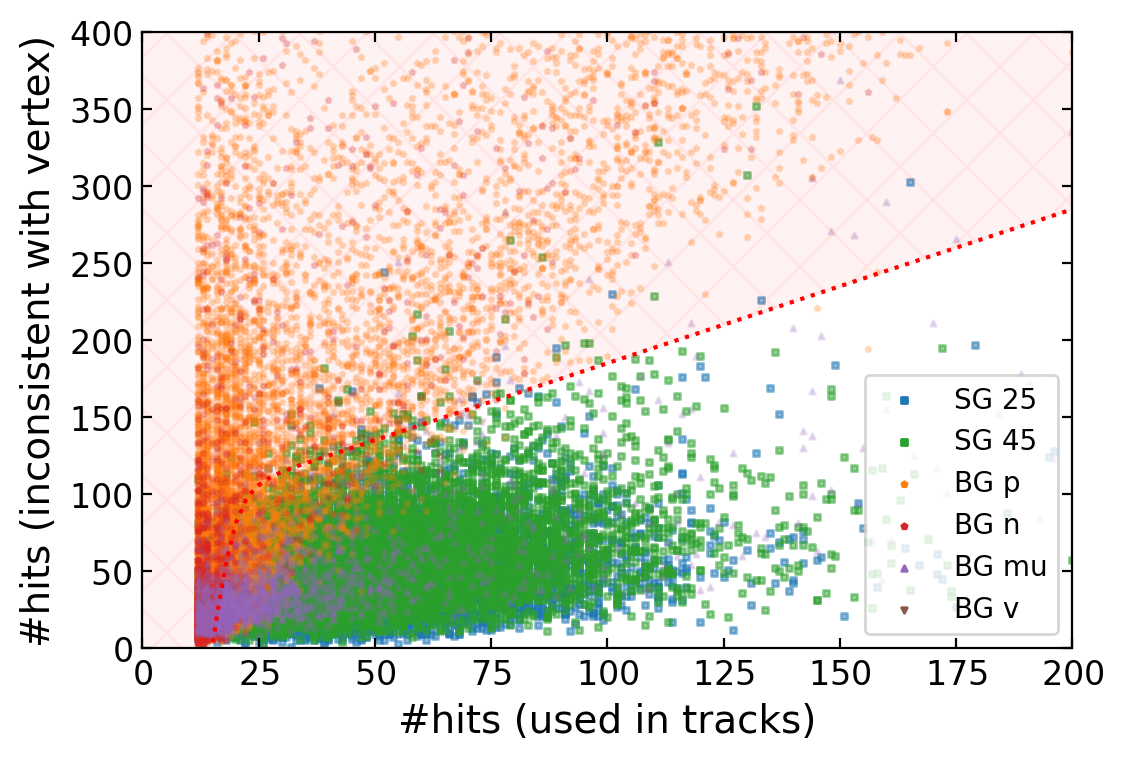

In [218]:
def f_nhits_cut2(x):
    x0 = 15
    squeeze = 5
    yscale = 100
    slope = 1
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    # return y * (y>20) + 20 * (y<=20)
    return y
    

for name, cfg in plot_settings.items():
    res = data[name]
    mask = res.get_cut("More than 2 tracks") & res.get_cut("Fiducial volume")#&res.get_cut("N_hits vs N_veto") #| res.get_cut("True")

    x = (res["event_track_nhits"])[mask]
    y = (res["event_nhits"]- res["vertex_ndigi_active_after_comp"])[mask]
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize)

xlim=200
ylim=400
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut2(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut2(x_plot), ylim, color="r", alpha=0.05, hatch="X")

plt.xlabel("#hits (used in tracks)")
plt.ylabel("#hits (inconsistent with vertex)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

lh = plt.legend(fontsize=10)
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque
    
save_fig("comb_n_veto_cut_2")

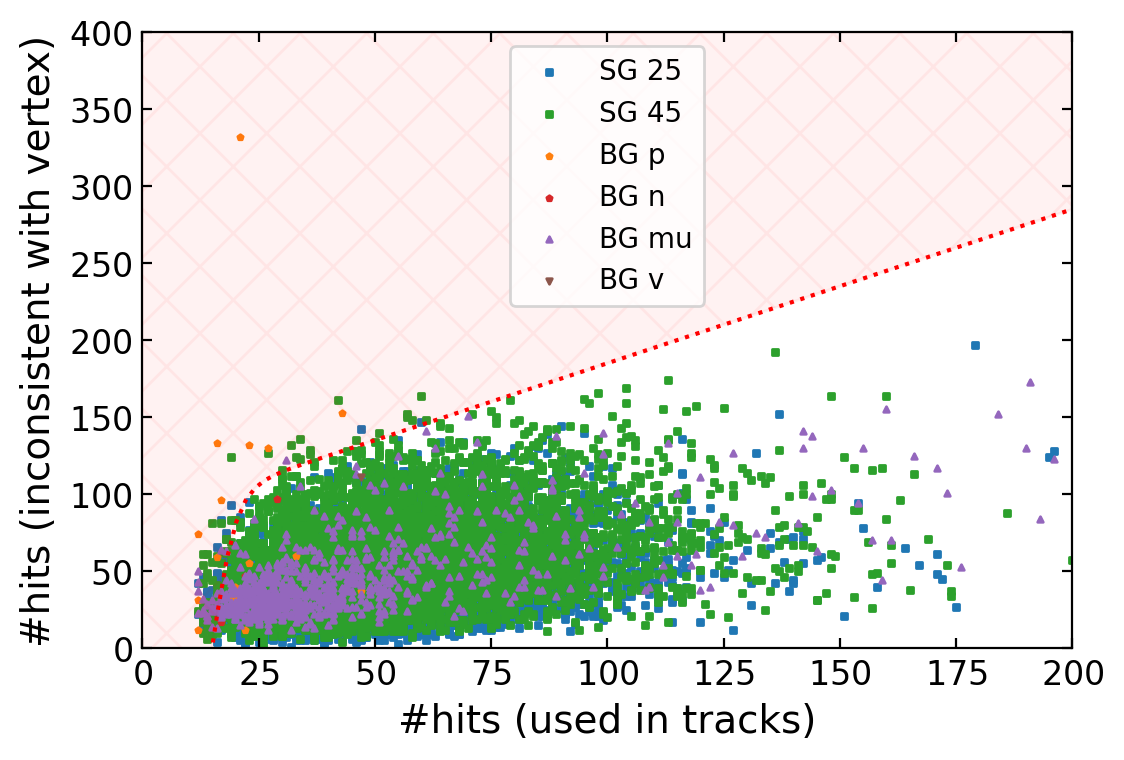

In [298]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask = res.get_cut("More than 2 tracks") & res.get_cut("Fiducial volume") &res.get_cut("N_hits vs N_veto") #| res.get_cut("True")

    x = (res["event_track_nhits"])[mask]
    y = (res["event_nhits"]- res["vertex_ndigi_active_after_comp"])[mask]
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=1, s=cfg.markersize)

xlim=200
ylim=400
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut2(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut2(x_plot), ylim, color="r", alpha=0.05, hatch="X")

plt.xlabel("#hits (used in tracks)")
plt.ylabel("#hits (inconsistent with vertex)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

lh = plt.legend(fontsize=10)
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque
    
save_fig("comb_n_veto_cut_2_combined")